# Demo Accessing ERDDAP Grid & Table Datasets

This is a demo of accessing `griddap` and `tabledap`
datasets from the SalishSeaCast ERDDAP server
(https://salishsea.eos.ubc.ca/erddap/).

In [1]:
%matplotlib inline

In [2]:
import cmocean
import pandas
import xarray

In [28]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    print(ds)

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 43896)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T00:30:00 ... 2020-01-09T23:30:00
  * depth        (depth) float32 0.5000003 1.5000031 ... 414.5341 441.4661
  * gridY        (gridY) int16 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
Data variables:
    salinity     (time, depth, gridY, gridX) float32 ...
    temperature  (time, depth, gridY, gridX) float32 ...
Attributes:
    acknowledgement:           MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    comment:                   If you use this dataset in your research,\nple...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             sallen@eoas.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    creator_url:               https://salishsea-meopar-docs.readthedocs.io/
    description: 

CPU times: user 120 ms, sys: 11.5 ms, total: 132 ms
Wall time: 644 ms


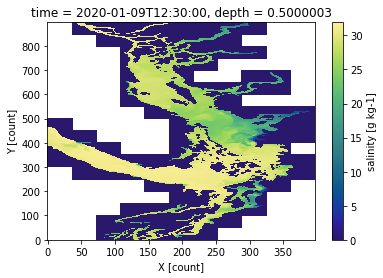

In [14]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .isel(depth=0)
         .sel(time="2020-01-09 12:30")
         .plot(cmap=cmocean.cm.haline))

CPU times: user 261 ms, sys: 12.8 ms, total: 273 ms
Wall time: 794 ms


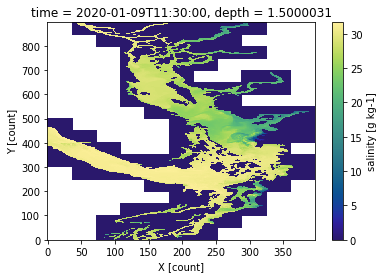

In [15]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(depth=2, time="2020-01-09 11:00", method="nearest")
         .plot(cmap=cmocean.cm.haline))

CPU times: user 56.9 ms, sys: 8.13 ms, total: 65.1 ms
Wall time: 3.6 s


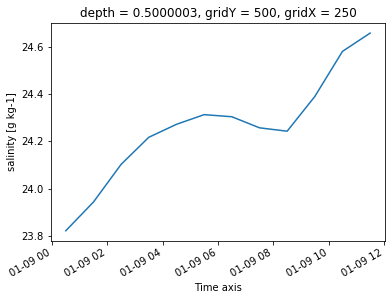

In [19]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
        .sel(depth=0, method="nearest")
        .sel(gridX=250, gridY=500, time=slice("2020-01-09 00:00", "2020-01-09 12:00"))
        .plot())

CPU times: user 66.4 ms, sys: 546 µs, total: 66.9 ms
Wall time: 13.1 s


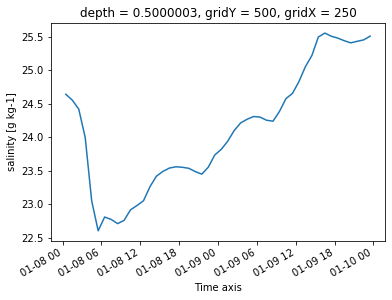

In [17]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(depth=0, method="nearest")
         .sel(gridX=250, gridY=500, time=slice("2020-01-08 00:00", "2020-01-10 00:00"))
         .plot())

CPU times: user 50.8 ms, sys: 11.2 ms, total: 62 ms
Wall time: 1.43 s


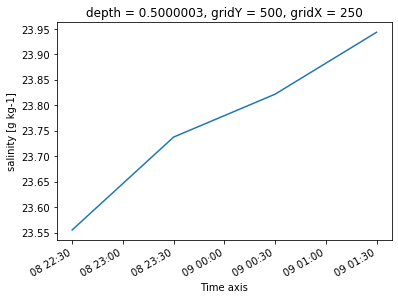

In [20]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(depth=0, method="nearest")
         .sel(gridX=250, gridY=500, time=slice("2020-01-08 22:00", "2020-01-09 02:00"))
         .plot())

CPU times: user 207 ms, sys: 4.47 ms, total: 212 ms
Wall time: 688 ms


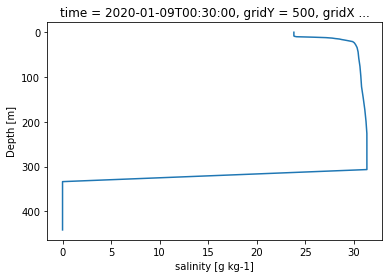

In [21]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(gridX=250, gridY=500, time="2020-01-09 00:00", method="nearest")
         .plot(y="depth", yincrease=False))

CPU times: user 191 ms, sys: 12.9 ms, total: 204 ms
Wall time: 711 ms


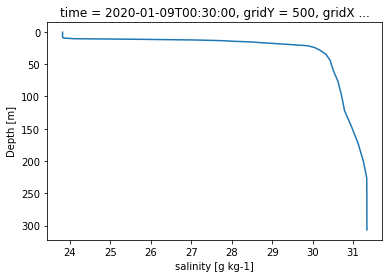

In [26]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    salinity = ds.salinity.sel(gridX=250, gridY=500, time="2020-01-09 00:00", method="nearest")
    salinity.where(salinity>0).plot(y="depth", yincrease=False)